In [84]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import concatenate

# Making numpy arrays of dataset

In [127]:
data_with_mask_path = '/face mask data/data/with_mask'
data_without_mask_path = '/face mask data/data/without_mask'

labels = ['with_mask', 'without_mask']
mask_dir = os.listdir(data_with_mask_path)
no_mask_dir = os.listdir(data_without_mask_path)
image_data = []
image_label = []
for image in mask_dir:
    img = cv2.imread(data_with_mask_path + '/' + image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    image_data.append(img)
    image_label.append(1)
for image in no_mask_dir:
    img = cv2.imread(data_without_mask_path + '/' + image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    image_data.append(img)
    image_label.append(0)
with_mask = image_data[:3725]
without_mask = image_data[3725: ]
with_mask_label = image_label[:3725]
without_mask_label = image_label[3725: ]
x_train = with_mask[1117:]
x_train.extend(without_mask[1148:])
x_test = with_mask[:1117]
x_test.extend(without_mask[:1148])
y_train = with_mask_label[1117:]
y_train.extend(without_mask_label[1148:])
y_test = with_mask_label[:1117]
y_test.extend(without_mask_label[:1148])
x_train = np.array(x_train).astype('float32')
y_train = np.array(y_train).astype('uint8')
x_test = np.array(x_test).astype('float32')
y_test = np.array(y_test).astype('uint8')

## Reshaping the data

In [133]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (5286, 28, 28, 1) 1.0
Testing (2265, 28, 28, 1) 1.0


###  Checking class districution

In [134]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [2680, 2606]
test groups: [1148, 1117]


### Generating Random batches for further testings

In [135]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

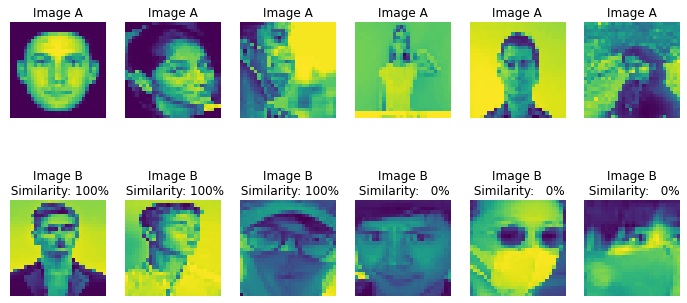

In [136]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

## Architecture of Siamese Network

#### Feature Extraction Part

In [137]:
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 

### Similarity model 

In [ ]:
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

### Training 

In [143]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae', 'accuracy'])


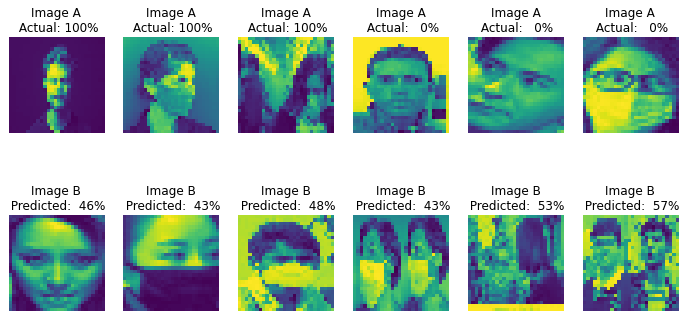

In [144]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [146]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 20,
                                             verbose = True)

Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 0.6053 - mae: 0.4361 - accuracy: 0.6793 - val_loss: 0.5220 - val_mae: 0.3814 - val_accuracy: 0.7554
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4552 - mae: 0.3159 - accuracy: 0.7914 - val_loss: 0.4363 - val_mae: 0.2801 - val_accuracy: 0.7856
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3392 - mae: 0.2267 - accuracy: 0.8594 - val_loss: 0.9322 - val_mae: 0.3708 - val_accuracy: 0.6362
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2522 - mae: 0.1631 - accuracy: 0.9016 - val_loss: 0.4451 - val_mae: 0.2116 - val_accuracy: 0.8076
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1663 - mae: 0.1078 - accuracy: 0.9398 - val_loss: 0.5523 - val_mae: 0.2199 - val_accuracy: 0.7954
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1359 - mae: 0.0827 - accuracy: 0.9521 - va

#### Output on a random batch of images

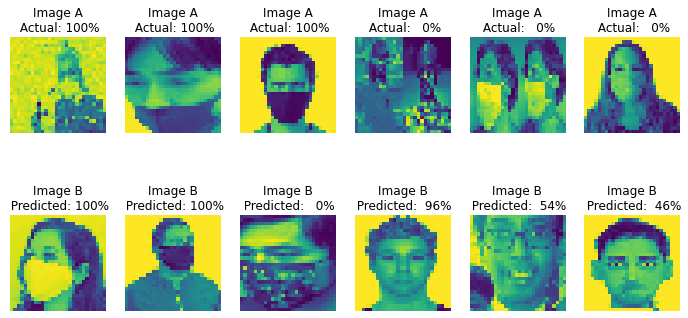

In [147]:
_ = show_model_output()
